<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/55_Ultra_Lite_%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81_%D0%BF%D0%BE%D0%B4%D0%BA%D1%80%D0%B5%D0%BF%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

Перепишите блоки занятия.

1. Моделируем нейросеть.

2. Задаем функцию потерь в соответствии с вознаграждением.

3. Генерация игрового эпизода с участием нейросети.

4. Обучаем сеть на серии игровых эпизодов.

Важно переписать эти блоки самостоятельно, не копируя. Копирование оставшихся блоков допускается.

# Загрузка библиотек

В связи с недавним обновлением библиотеки gym, попытки создать игровую среду pong-v0 (или любую другую) теперь вызывают ошибку.

Следующий код является временной мерой для избежания этой ошибки.

Здесь меняется версия библиотек. Этот код был добавлен 28 мая. Когда обновят gym и уберут критичный баг, этот код будет удален.


In [ ]:
!pip install gym==0.18.3
!pip install atari-py==0.2.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gym # загружаем "тренажер" Gym из библиотеки OpenAI, предоставляющий среду для работы над обучением с подкреплением

import numpy as np 
import tensorflow.keras as keras # импортируем нейросетевую библиотеку

from tensorflow.keras.models import Model, load_model # из Кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # слои
from tensorflow.keras.utils import plot_model # функция визуализации модели
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

import time
import matplotlib.pyplot as plt
import tensorflow as tf
# для запуска библиотеки в ноутбуке
%matplotlib inline 

In [ ]:
# Отключаем функционал tf2.0, чтобы код был совместим с современным tensorflow
tf.compat.v1.disable_eager_execution()

# Взгляд на игру

In [ ]:
env = gym.make('Pong-v0') # создаем среду игры Pong средствами  OpenAI Gym ('env' = enviroment)
observation = env.reset() # задаем начальное состояние среды, которое наблюдает агент
observation.shape # взглянем на формусостояния среды
# увидим, что это изображение размером 210*160 с тремя RGB

(210, 160, 3)

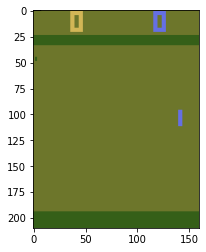

In [ ]:
plt.imshow(observation) # вызовем визуализацию состояния среды с помощью метода imshow()
plt.show()

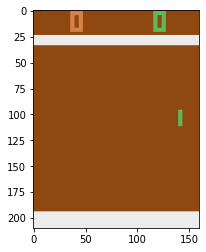

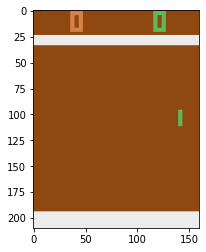

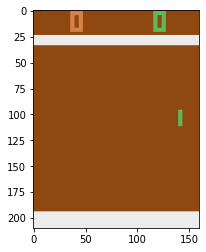

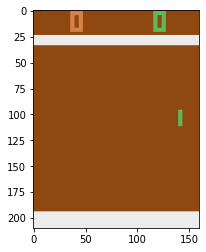

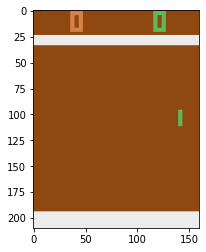

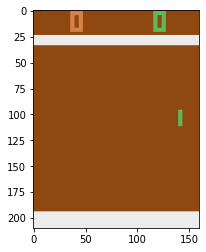

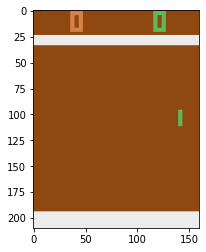

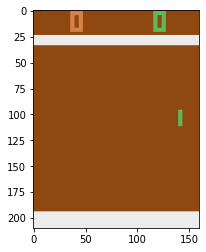

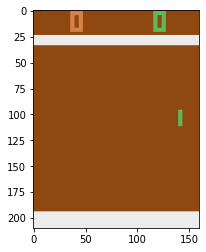

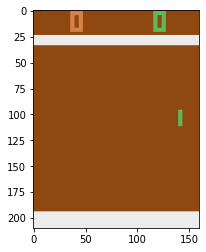

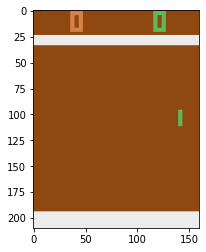

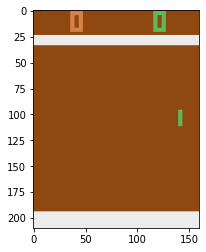

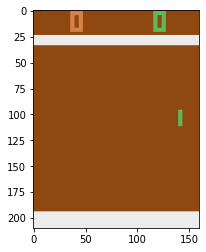

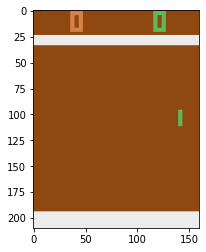

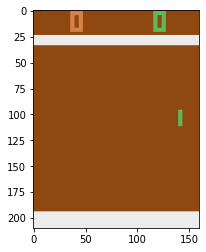

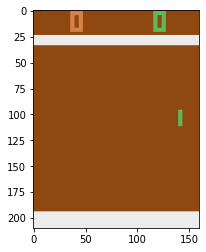

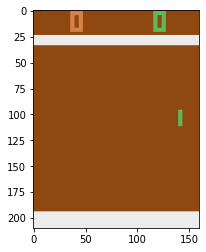

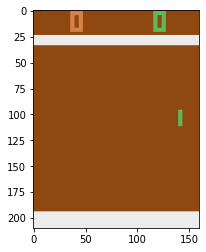

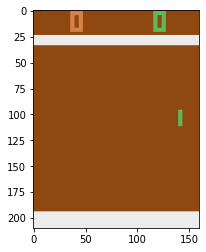

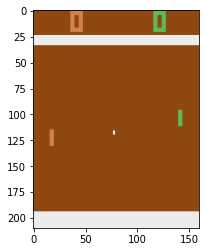

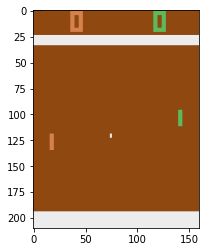

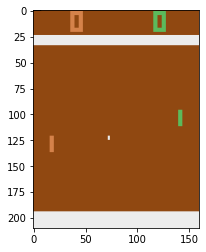

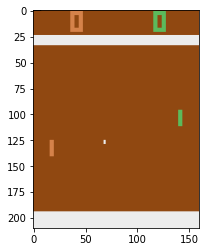

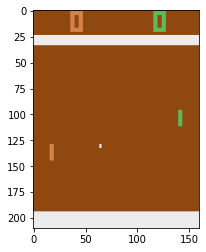

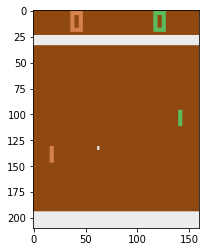

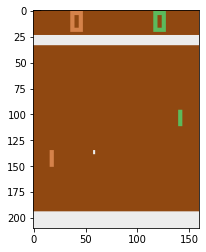

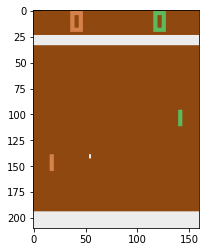

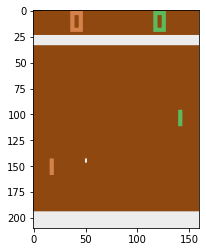

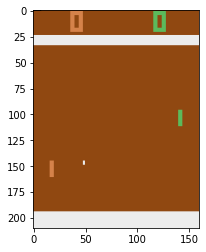

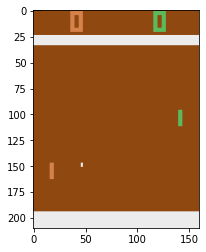

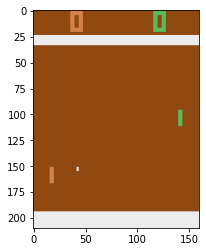

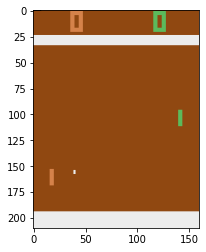

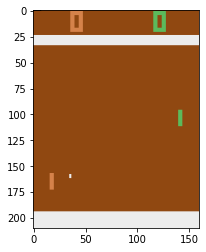

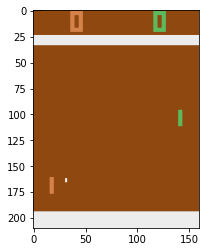

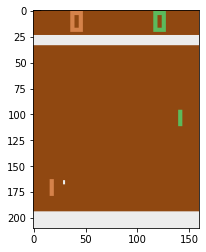

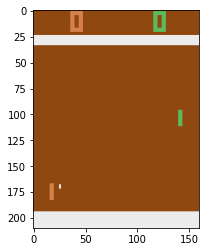

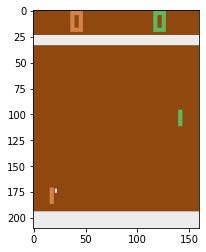

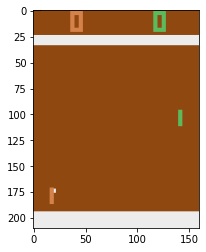

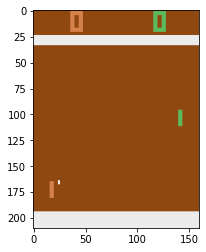

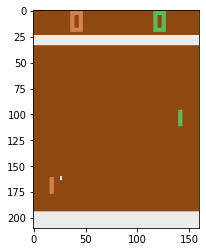

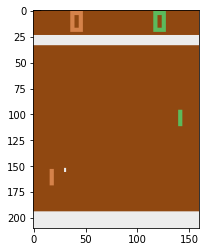

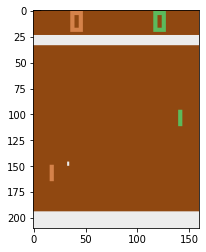

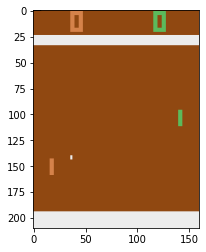

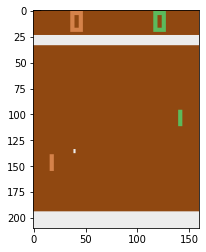

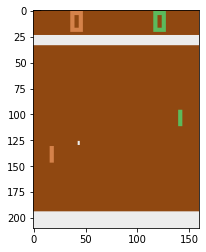

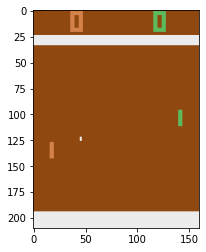

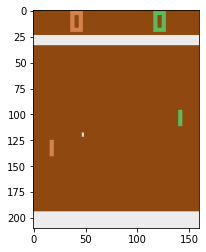

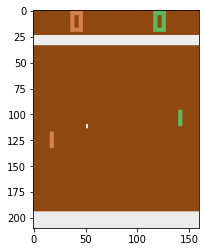

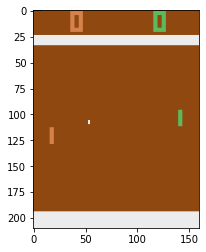

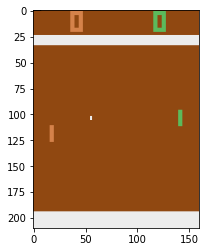

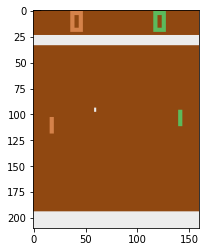

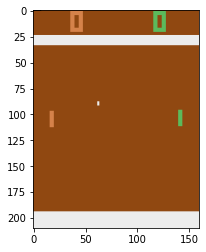

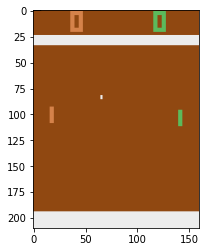

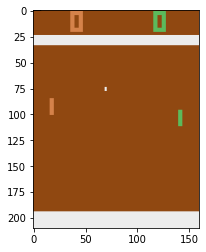

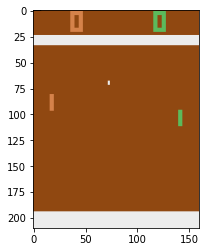

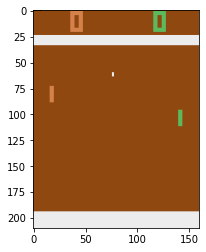

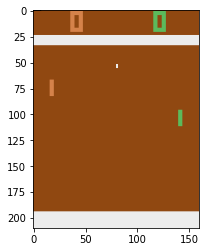

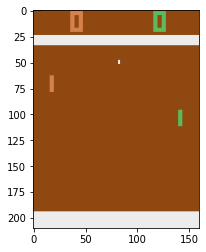

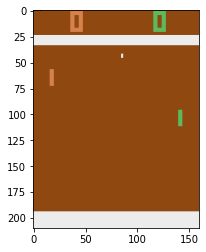

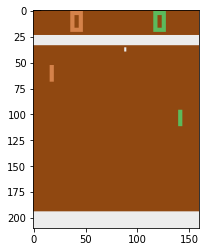

'\nstep - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)\nobservation (object) - текущее состояние среды, которое наблюдает агент (пиксели)\nreward (float) - награда за совершенное действие\ndone (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)\ninfo (dict) - вспомогательная диагностическая информация\n'

In [ ]:
# Обозначения:
# 0 - ракетка остается на месте
# 1 - сдвинуться вверх
# 2 - сдвинуться вниз

# Проиграем игру на 30 кадров, чтобы увидеть полную сцену игры
for i in range(60):
  #env.render()
  observation, reward, done, info = env.step(0) # 0 обозначает, что ничего не делаем, остаемся на месте
  plt.imshow(observation) # взглянем на текущее состояние среды: наш агент владеет зеленой ракеткой, появился мяч и соперник
  plt.show()
  
'''
step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)
observation (object) - текущее состояние среды, которое наблюдает агент (пиксели)
reward (float) - награда за совершенное действие
done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)
info (dict) - вспомогательная диагностическая информация
'''

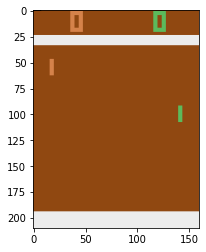

In [ ]:
# Policy (политику, стратегию агента) будет позже задавать нейросеть.
# Мы подадим ей разницу между новым и предыдущим кадром, 
# чтобы отслеживалось смещение мяча/ракеток и данные были понятными
newObservation, reward, done, info = env.step(2) # задаем очередным шагом следующий кадр, при этом смещая ракетку вверх
plt.imshow(newObservation) # взглянем на следующий кадр (нам смещение едва видно или не видно)


# Предобработка данных

In [ ]:
# Зададим функцию предобработки данных для подачи в нейросеть
# избавимся от всего лишнего (фон, размер и т.п.), оставив на эеране лишь мяч и ракетки
def preprocessFrames(newFrame, lastFrame): # подаем в функцию новый и предыдущий кадр
  nFrame = newFrame.astype(np.int32)      # переводим новый кадр в целочисленный тип
  nFrame[nFrame==144] == 0                 # удаляем цвета заднего фона в новом кадре (144 и 72 - значения каналов, дающих оранжевый цвет, зануляем )
  nFrame[nFrame==72] == 0
  lFrame = lastFrame.astype(np.int32)      # тоже самое делаем с предыдущим кадром
  lFrame[lFrame==144] == 0
  lFrame[lFrame==72]  == 0
  deltaFrame = nFrame - lFrame             # задаем разницу между новым и предыдущим кадром
  # Отрезаем верхнюю и нижнюю неинформитивные части экрана
  deltaFrame = deltaFrame[35:195]          # срезали края по высоте, осталась картинка 160*160
  # Делаем сжатие кадро в 2 раза по обеим сторонам изображения и оставляем монотонный канал
  deltaFrame = deltaFrame[::2, ::2, 0]  
  # Масштабирование чисел от 0 до 1
  maxValue = deltaFrame.max() if deltaFrame.max() > abs(deltaFrame.min()) else  abs(deltaFrame.min())
  if maxValue != 0:
    deltaFrame = deltaFrame/maxValue
  return deltaFrame

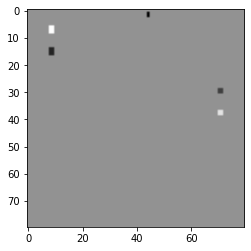

In [ ]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray) # выведем результат предобработки наших кадров
# смещение здесь - это шаг от черного к светлому

In [ ]:
# Выведем массив для этого состояния среды кадра
preprocessFrames(newObservation, observation)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
'''
Состоянием среды здесь будет картинка 80*80, полученная вычитанием двух последовательных кадров, где по итогу все будет...
заполнено нулями, а в местах смещения мяча либо ракетки - ненулевые значения.
Далее keras'ом создадим Policy, которая на основе состояния (картинки) выбирает действия.
Output сети - вероятность того, что нужно двигаться вверх.  
'''

# Выведем форму массива
preprocessFrames(newObservation, observation).shape

(80, 80)

# Моделируем нейросеть

In [ ]:
# Простая модель с 2мя слоями на 200 нейронов в скрытом слое и сигмоидой на выходе
inputs = Input(shape=(80,80)) # на входном слое сетки изображение 80*80
flattenedLayer = Flatten()(inputs)
fullconnected = Dense(200, activation='relu', use_bias=False)(flattenedLayer) # задали 200 нейронов + активация релу
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullconnected) # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)
policyNetworkModel.summary() # посмотрим на модель

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 80)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 200)               1280000   
                                                                 
 dense_5 (Dense)             (None, 1)                 200       
                                                                 
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


# Задаем функцию потерь в соответствии с вознаграждением

In [ ]:
# episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поржения вызываем reset )
episodeReward = Input(shape=(1,), name='episodeReward') # задаем награду за эпизод

In [ ]:
'''
Функция потерь в Керасе имеет вид def loss(yTrue, yPred): ... А так как нам нужно включить Reward в loss, создаем 
функцию поверх нее, чтобы на выходе добавить episodeReward
'''
def rewardedLoss(episodeReward): # задаем новую функцию потерь, принимающую на вход episodeReward - награду
  def loss(yTrue, yPred):
    '''
    Подаем в качестве yTrue фактически сделанное действие - action.
    Если это действие было движением вверх - подаем 1 на yTrue, иначе подаем 0.
    yPred - выход сетки - это вероятность выбора движения вверх. 
    Мы не подаем yPred в нейронку , его вычисляет Керас.
    '''
    # Сначала log(0) и log(1) неопределены - загоняем yPred между значениями
    tmpPred = Lambda(lambda x: keras.backend.clip(x, 0.05, 0.95))(yPred)
    # Вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх. 
    # Помним, что yTrue = 1, когда фактически выбрано движение вверх, и 0 - когда вних. 
    # Формула похожа на кросс-энтропию в керасе, но здесь мы прописываем ее вручную, чтобы умножить на значение
    tmpLoss = Lambda(lambda x: -yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    # Обновленная функция потерь = "Функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward]) # добавляем в loss умножение на награду за эпизод
    return policyLoss # ввели обновленную функцию политики
  return loss # возвращаем обновленную функцию политики



In [ ]:
'''
Создаем керас-оптимизатор и нейронку для обучения
'''
episodeReward = Input(shape=(1,), name='episodeReward') # звдвем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward], outputs = sigmoidOutput) # задаем сеть с добавлением на вход награды

myOptimizer = RMSprop(lr=0.0001)
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# Генерация игрового эпизода с участием нейросети


In [ ]:
'''
Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети

Игра начнется с того, что в новом эпизоде наш агент сделает движение ("actualAction") вверх с вероятностью ("upProbability")
которую предстказала наша сетка PolicyNetwork, принявшая на вход состояние среды reshapedInput с подогнанной под сеть формой.
reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим
кадром, полученную функцией preprocessFrames.

'''

def generateEpisode(policyNetwork): # подаем на вход модель нейросети
  statesList = []                    # список состояний в течение эпизода, размер = (х, 80, 80)
  upDownActionList = []             # список движеий в течение эпизода
  rewardsList = []                  # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность, что нужно идти вверх; собираем список из вероятнсти на каждом шаге
  env = gym.make('Pong-v0')         # создали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен, не завершен

  while done == False: # пока игровой эпизод не завершен
    # На вход сети будет подаваться очередное состояние - разница между кадрами
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствии станет х-ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер х (80, 80), делаем размерность (1, 80, 80)

    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх

    networkOutputList.append(upProbability) # добавляем вероятность идти вверх к списку вероятностей
    actualAction = np.random.choice(a=[2, 3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактически шаг либо вверх (2) с вероятностью upProbability, либо вниз (3) с обратной вероятностью

    if actualAction == 2:           # если пошли вверх 
      upDownActionList.append(1.0)  # добавляем единицу в список движений в течение эпизода
    else:                           # если не пошли вверх
      upDownActionList.append(0.0)  # то добавляем ноль
    
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние

    rewardsList.append(reward)   # добавили текущую награду в список

    if done:  # если игровой эпизод закончен
      break   # завершаем цикл

  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает :
  # список состояний в течение эпизода
  # список движений в течение эпизода
  # список наград за каждое действие
  # список вероятностей того, что нужно идти вверх

In [ ]:
'''
Сгенерируем эпизод игры с необученной сетью 
'''
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print('----------------------')
print('Количество состояний в эпизоде ='+str(len(statesList))) # количество кадров в эпизоде
print('Форма состояния '+str(statesList[0].shape))             # форма каждого состояния
print('Количество наград за эпизод '+str(len(rewardsList)))    # количество наград за эпизод, включая нулевые 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


----------------------
Количество состояний в эпизоде =1338
Форма состояния (80, 80)
Количество наград за эпизод 1338


In [ ]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге
print(networkOutputList[50:70])
# увидим, что на каждом шаге вероятность крутится около 50% - сеть пока не понимает куда лучше шагать

[0.49590114, 0.5060372, 0.4941813, 0.48397037, 0.5073266, 0.4853329, 0.5105633, 0.48915312, 0.4983012, 0.49379572, 0.49297962, 0.49821657, 0.5011123, 0.50508934, 0.48122782, 0.50652874, 0.5179972, 0.4883319, 0.5029525, 0.48100042]


In [ ]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# соответственно шаги также были случайными

[1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0]

In [ ]:
# Выведем список наград (везде нули, когда выигрываем или проигрываем очко)
print(rewardsList[50:70])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Взглянем на то, сколько раз мы выигрывали внутри эпизода:
print('Количество выигранных очков = '+str(len(list(filter(lambda r: r>0, rewardsList))))) # берем как длину списка, отфильтрованного по наградам больше нуля
print('Количество проиганных очков = ' +str(len(list(filter(lambda r: r<0, rewardsList)))))# берем как длину списка, отфильтрованного по наградам меньше нуля
print('Количество нулевых наград = '+str(len(list(filter(lambda r: r==0, rewardsList)))))  # с фильтром по 0

Количество выигранных очков = 0
Количество проиганных очков = 21
Количество нулевых наград = 1317


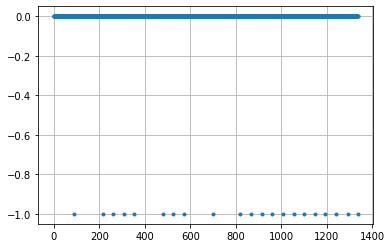

In [ ]:
# Выведем на графике полученные награды. Ненулевые награды за каждое очко будут отмечены точками. 
plt.plot(rewardsList, '.') # точки будут наградами на графике
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой   


# Эффективно определяем вознаграждение

In [ ]:
# ''' !!! Найти ошибку
# Награды пока присуждаются тем, движениям, в момент которых было пропущено илизабито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбиваем мяч ракеткой. Чтобы сетка поняла, что отбивать мяч - это хорошо, 
# распределим награду за все шаги, предшествующие забитому/пропущенному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.

# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
# '''
# def processRewards(rewardList):   # подадим в функцию список наград
#   rewardDecay = 0.99              # установим верхний коэффициент наград для соседнего/ближайшего действия к победному/проигранному действию (т.е. идем с конца)
#   tmpReward = 0                   # создадим временную переменную для награды
#   rewardDecayed = np.zeros_like(rewardList, dtype=np.float32) # создадим массив из нулей для нового формата наград
#   for i in range(len(rewardsList)-1, -1, -1): #будем идти в обратную сторону от награды с шагом "-1"
#     if rewardList[i] == 0:
#       tmpReward = tmpReward*rewardDecay   # зададим ей коэффициент
#       rewardDecayed[i] = tmpReward        # и добавим в массив
#     else:
#       tmpReward = rewardList[i]           # оставим награду неизменной
#       rewardDecayed[i] = tmpReward        # и введем в томже виде в массив
#   # Запустим нормализацию значений наград, что позволит сетке лучше понимать , где были хорошие и плохие шаги
#   rewardDecayed -=np.mean(rewardDecayed)  # вычтем среднее
#   rewardDecayed /=np.std(rewardDecayed)   # разделим на стандартное отклонение
#   return rewardDecayed
#   # функция возвращает обновленный формат наград

In [ ]:
'''
Награды пока присуждаются тем, движениям, в момент которых было пропущено илизабито очко. Но так мы научимся нескоро,
нам нужно указать на важность действия чуть ранее, когда мы отбиваем мяч ракеткой. Чтобы сетка поняла, что отбивать мяч - это хорошо, 
распределим награду за все шаги, предшествующие забитому/пропущенному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.

Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
'''
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1, -1, -1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая 
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed

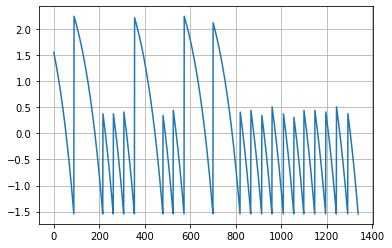

In [ ]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList), '-') # добавляем в график награды с учетом новой функции
ax = plt.gca() # получим текущие оси с новой сеткой
ax.grid(True)  # с фоновой сеткой

# Пример игрового эпизода с последующей тренировкой сети

In [ ]:
# Сгенерируем новый игровой эпизод
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
# Сыграли до 21 очка, проиграли, получили списки всех состояний среды (кадров), шагов агента, вознаграждений и предсказаний

print('Количество состояний среды: '+str(len(statesList)))   # выведем количество состояний кадров
print('Форма состояний среды '+str(statesList[0].shape))     # выведем форму для каждого состояния
print('Список наград ='+str(len(rewardsList)))               # выведем список наград в игровом эпизоде(включая нулевые)


Количество состояний среды: 1190
Форма состояний среды (80, 80)
Список наград =1190


In [ ]:
# Подготовим данные для тренировки
x = np.array(statesList)  # зададим "х" как массив состояний
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList) # зададим "у" как список движений вверх (1)/вниз (0)
yTrue = np.expand_dims(yTmp, 1)   # скорректируем форму под сетку

print('Форма наград за эпизод = ', episodeReward.shape) # выведем форму наград за эпизод
print('Форма состояний среды = ', x.shape)              # выведем форму состояний среды ("х" для нейросети)
print('Форма фактических движений =', yTrue.shape)      # выведем форму фактических движений ("у" для нейросети)

Форма наград за эпизод =  (1190, 1)
Форма состояний среды =  (1190, 80, 80)
Форма фактических движений = (1190, 1)


In [ ]:
episodeReward[:20]

array([[1.8902034],
       [1.865578 ],
       [1.8407042],
       [1.815579 ],
       [1.7902001],
       [1.7645649],
       [1.7386707],
       [1.7125149],
       [1.6860949],
       [1.659408 ],
       [1.6324517],
       [1.6052228],
       [1.5777192],
       [1.5499376],
       [1.5218754],
       [1.4935297],
       [1.4648978],
       [1.4359766],
       [1.4067632],
       [1.3772547]], dtype=float32)

In [ ]:
# Скормим модели новые "х" и "у"
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Train on 1190 samples
1190/1190 [==============================] - 1s 690us/sample - loss: -5.1489e-04


In [ ]:
'''
Теперь создадим серию игровых эпизодов.
Затем предобработаем данные и скормим их нейросети.
'''
def generateEpisodeBatchesTraining(model, nBatches=10):
  env = gym.make('Pong-v0')              # создаем игровую среду Pong
  batchStateList = []                  # зададим серию списков состояний
  batchUpDownActionList = []           # зададим серию списков движений
  batchRewardsList = []                # зададим серию списков наград
  batchNetworkOutputList = []          # зададим серию списков из вероятности идти вверх
  for i in range(nBatches):            # для каждой серии
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
    batchStateList.extend(statesList)                # добавим список состояний в серию списков состояний
    batchNetworkOutputList.extend(networkOutputList) # добавим список вероятности в серию списков из вероятностей идти вверх или вниз
    batchUpDownActionList.extend(upDownActionList)   # добавим список движений в серию списков движений
    batchRewardsList.extend(rewardsList)              # добавим список наград в серию списков наград

  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
  x = np.array(batchStateList)                 # cформируем массив из серии списков состояний в качестве "х" для нейросети
  yTmp = np.array(batchUpDownActionList)       # зададим "у" как серию списков движений вверх(1)/вниз(0)
  yTrue = np.expand_dims(yTmp, 1)              # подгоним форму "у" массива с добавлением оси

  history = policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue, epochs=5, verbose=0) # подаем в нейронку серию "х"ов и "у"ов
  
  
  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
  # функция вернет серию списков состояний, движений, наград, а также серию списков из вероятностей двигаться вверх



# Обучаем сеть на серии игровых эпизодов


In [ ]:
trainingTimes = 121                   # установим количество тренировок
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов (1 эпоха - 10 игр)
  statesList, upDownActionList, rewardsList, networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10)
  endTime = time.time()
  print('Тренировка =' + str((training)+1))                            # выведем на экран номер очередной тренировки
  print('Время тренировки =' + str(round(endTime - startTime)) +'сек') # время тренировки
  print('Ошибка на тренировке = ' + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr = np.array(rewardsList)                                           # сформируем все награды
  print('Выиграли очков = ' + str(len(rr[rr>0])) + 'Проиграли очков =' + str(len(rr[rr<0]))) #  выведем на экран сумму выигранных и проигранных очков
  print('')
  if training % 10 == 0: # через каждые 10 эпизодов
    policyNetworkModel.save('policyNetworkModel.h5')                      # сохраним модель
    policyNetworkModel.save('policyNetworkModel' + str(training) + 'h.5') # и для удобства сохраним модельв памяти с количеством тренировок в названии
    with open('rewardsModelSimple.txt', 'a') as recordingRewards:         # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write('training =' + str(training) + 'выигранных очков = ' + str(len(rr[rr>0])))
      recordingRewards.write('\n')



Тренировка =1
Время тренировки =116сек
Ошибка на тренировке = -0.0434
Выиграли очков = 10Проиграли очков =210

Тренировка =2
Время тренировки =116сек
Ошибка на тренировке = -0.0546
Выиграли очков = 8Проиграли очков =210

Тренировка =3
Время тренировки =124сек
Ошибка на тренировке = -0.03928
Выиграли очков = 11Проиграли очков =210

Тренировка =4
Время тренировки =134сек
Ошибка на тренировке = -0.04158
Выиграли очков = 11Проиграли очков =210

Тренировка =5
Время тренировки =110сек
Ошибка на тренировке = -0.04373
Выиграли очков = 9Проиграли очков =210

Тренировка =6
Время тренировки =127сек
Ошибка на тренировке = -0.05304
Выиграли очков = 10Проиграли очков =210

Тренировка =7
Время тренировки =130сек
Ошибка на тренировке = -0.06963
Выиграли очков = 9Проиграли очков =210

Тренировка =8
Время тренировки =148сек
Ошибка на тренировке = -0.04281
Выиграли очков = 12Проиграли очков =210

Тренировка =9
Время тренировки =143сек
Ошибка на тренировке = -0.04961
Выиграли очков = 10Проиграли очков =21